# Prosup  Classifier

In [1]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Data Analysis Section

In [2]:
file = 'Subjects/Nikhil/computed_Hammer.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle']
df = pd.read_csv(file,index_col=0)

In [3]:
b,a = signal.butter(3, 3,fs=2000)
for labels in emg_labels:
    df[labels] = signal.lfilter(b, a,abs(df[labels]))

In [4]:
b,a = signal.butter(3, 3,fs=2000)
for labels in angle_lables:
    df[labels] = signal.lfilter(b, a,df[labels])

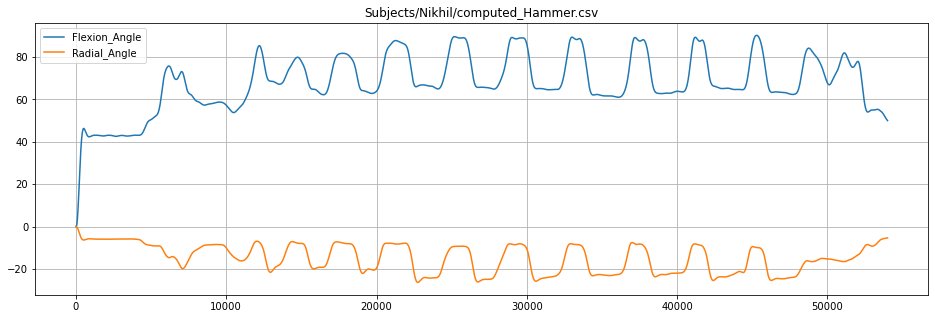

In [5]:
df[['Flexion_Angle','Radial_Angle']].plot(figsize=(16,5),title=file,grid=True)#,xticks=np.linspace(0,len(df),5)
df = df[10000:50000]#[6500:85000]

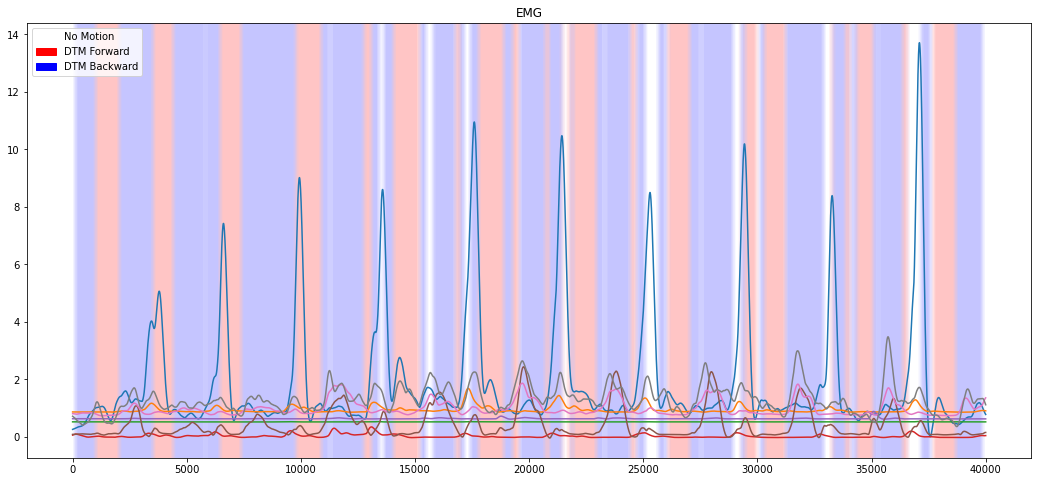

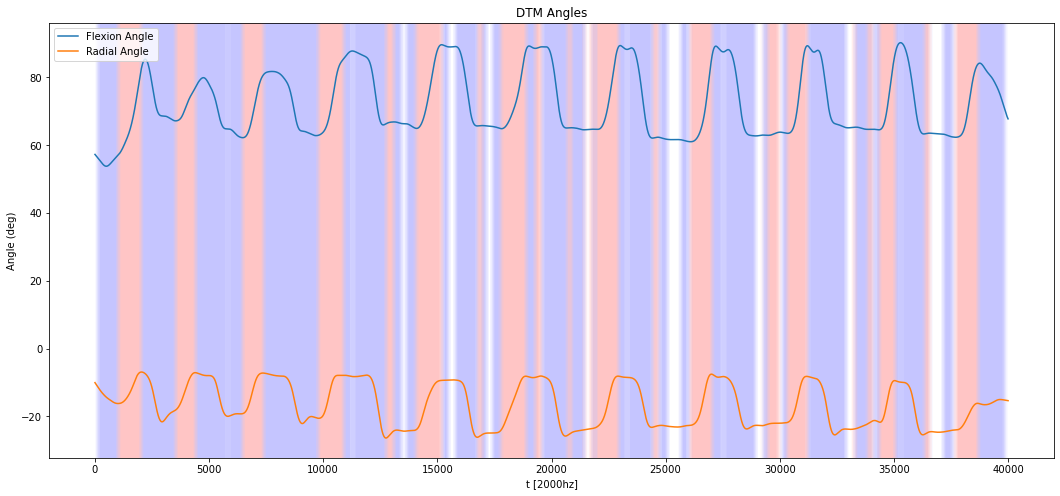

0 -> 9.119496855345911 %
1 -> 32.515723270440255 %
2 -> 58.36477987421384 %


((1590, 250, 8), (1590, 3))

In [6]:
X, y = prep_data_DTM(df,250,interval=25,Normalize=True,plot=True,angle_thresh=0.001,rms=False)
X.shape,y.shape

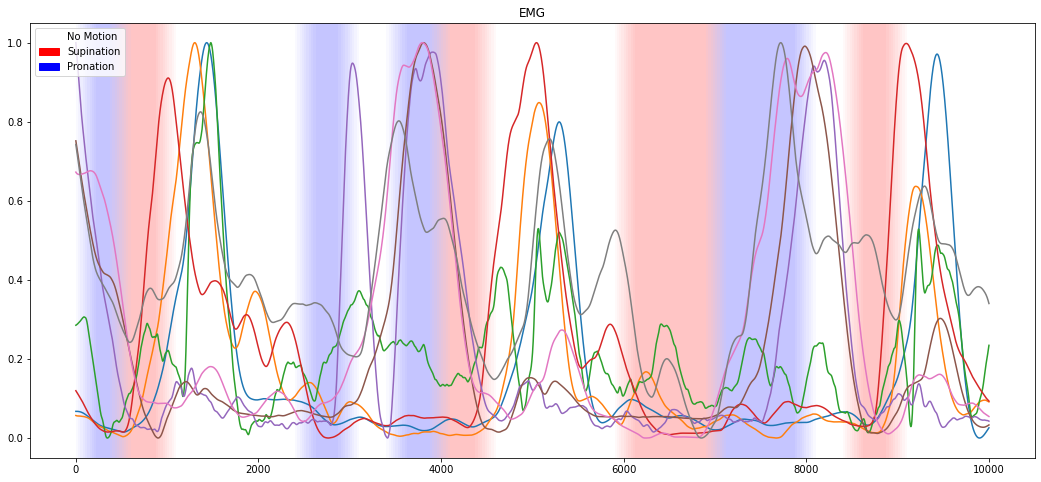

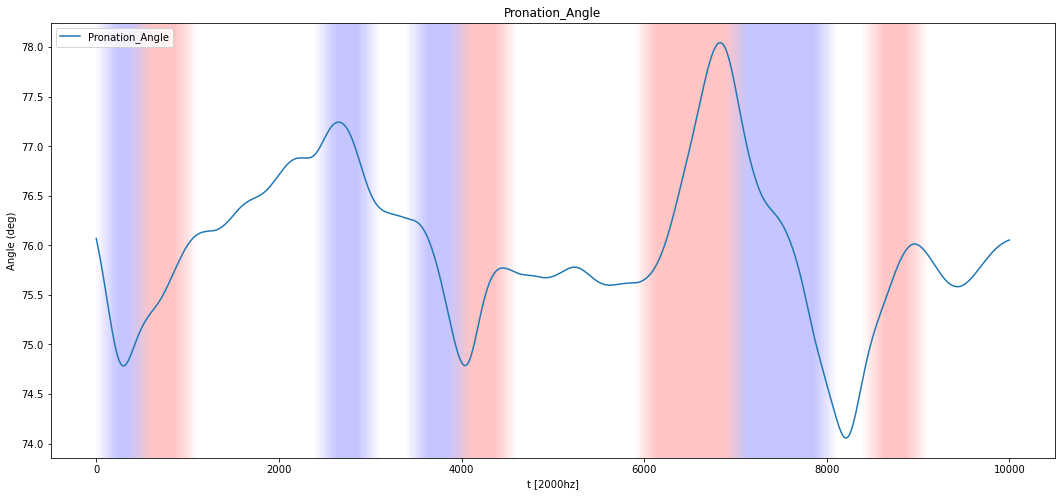

0 -> 51.02564102564103 %
1 -> 25.384615384615383 %
2 -> 23.58974358974359 %


((390, 250, 8), (390, 3))

In [80]:
X, y = prep_data_prosup(df[20000:30000],250,interval=25,Normalize=True,plot=True,angle_thresh=0.001,rms=False)
X.shape,y.shape

In [55]:
Xn = X.reshape(X.shape[0]*X.shape[1],8)
for i in range(len(emg_labels)):
    print(emg_labels[i],'-',Xn[:,i].max())

EMG1 - 1.0
EMG2 - 0.9999999999999999
EMG3 - 1.0
EMG4 - 1.0
EMG5 - 1.0
EMG6 - 1.0
EMG7 - 1.0
EMG8 - 0.9999999999999999


## File Name Generation

In [23]:
files = []
subjects = ['Fazil','Nikhil','Abhishek','Jai', 'Deepti', 'Nirmayee','Ingy','Varun'] #'Fazil/day_04_14_21' ,'Varun'
# subjects = ['Varun'] #'Fazil/day_04_14_21' ,'Varun'

In [24]:
for subj in subjects:
    path = 'Subjects/'+subj
    trial_names = ['Bulb','Screw'] # 'Bulb','Hammer' ,'Cup',
#     trial_names = ['Bulb','Hammer' ,'Cup','Screw']
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                files.append(path+'/computed_'+exp+'.csv')
            else:
                files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Fazil/computed_Bulb.csv',
 'Subjects/Fazil/computed_Bulb01.csv',
 'Subjects/Fazil/computed_Bulb02.csv',
 'Subjects/Fazil/computed_Screw.csv',
 'Subjects/Fazil/computed_Screw01.csv',
 'Subjects/Fazil/computed_Screw02.csv',
 'Subjects/Nikhil/computed_Bulb.csv',
 'Subjects/Nikhil/computed_Bulb01.csv',
 'Subjects/Nikhil/computed_Bulb02.csv',
 'Subjects/Nikhil/computed_Screw.csv',
 'Subjects/Nikhil/computed_Screw01.csv',
 'Subjects/Nikhil/computed_Screw02.csv',
 'Subjects/Abhishek/computed_Bulb.csv',
 'Subjects/Abhishek/computed_Bulb01.csv',
 'Subjects/Abhishek/computed_Bulb02.csv',
 'Subjects/Abhishek/computed_Screw.csv',
 'Subjects/Abhishek/computed_Screw01.csv',
 'Subjects/Abhishek/computed_Screw02.csv',
 'Subjects/Jai/computed_Bulb.csv',
 'Subjects/Jai/computed_Bulb01.csv',
 'Subjects/Jai/computed_Bulb02.csv',
 'Subjects/Jai/computed_Screw.csv',
 'Subjects/Jai/computed_Screw01.csv',
 'Subjects/Jai/computed_Screw02.csv',
 'Subjects/Deepti/computed_Bulb.csv',
 'Subjects/Deepti/

In [25]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0))#[6500:85000])#[4500:85000]

In [26]:
def filter_df(files_df,order=1,cf=50,fs=2000):
    emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
    angle_lables = ['Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle']
    
    for i in range(len(files_df)):
        b,a = signal.butter(3, 3,fs=fs)
        emg_df = pd.DataFrame(columns=emg_labels)
        for labels in emg_labels:
            emg_df[labels] = signal.lfilter(b, a,abs(files_df[i][labels]))
        files_df[i][emg_labels] = np.array(emg_df)
        
        b,a = signal.butter(3, 3,fs=2000)
        for labels in angle_lables:
            files_df[i][labels] = signal.lfilter(b, a,files_df[i][labels])
            
    return files_df

In [27]:
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']

In [33]:
files_df = filter_df(files_df)

### Remove Test Reps Data

In [37]:
test_rep_files = ['Subjects/Nikhil/computed_Bulb02.csv',
                  'Subjects/Abhishek/computed_Bulb02.csv']
tr_range = [20000,30000]

In [29]:
files_df = []
for file in files:
    if file in test_rep_files:
        df = pd.read_csv(file,index_col=0)
        df = df.drop(df.index[tr_range[0]:tr_range[1]])
    else:
        df = pd.read_csv(file,index_col=0)
    files_df.append(df)
files_df = filter_df(files_df)

### Only Removed Reps

In [38]:
files_df = []
files = test_rep_files
for file in files:
    df = pd.read_csv(file,index_col=0)
    files_df.append(df[tr_range[0]:tr_range[1]])
files_df = filter_df(files_df)

C:\Users\Jiyeon_Kang\Desktop\Fazil_files\wrist_data_collection_AWEAR-main\Data_preparation_Library.py:582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files_df[i][emg_labels] = np.array(emg_df)
c:\python 3.8\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


## Data Augumentation

### Gausian Noise

In [11]:
files_df_gausian = []
for df in tqdm(files_df):
    snr = choice(np.linspace(60,90,5))
    emg_array = np.array(add__Gausian_noise(df[emg_labels],snr))
    df[emg_labels] = emg_array
    files_df_gausian.append(df)

files_df = files_df+files_df_gausian
len(files_df)

44

### Rearrange 

In [30]:
from collections import deque
rearr_labels = []
labels = deque(emg_labels)
labels.rotate(1)
rearr_labels.append(list(labels))
labels.rotate(-2)
rearr_labels.append(list(labels))
rearr_labels

[['EMG8', 'EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7'],
 ['EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG1']]

In [31]:
files_df_rearrange = []
for df in tqdm(files_df):
    for lb in rearr_labels:
        df[emg_labels] = df[lb]
        files_df_rearrange.append(df) 
    
files_df = files_df+files_df_rearrange
len(files_df)

144

## Data Prep Pipeline

### Parameters

In [39]:
window = 250
interval = 25
Normalize = True
rms = False
angle_thresh = 0.001

In [40]:
X_prosup, y_prosup = multiple_prep_data_prosup_bin(files_df,
                                      window,
                                      interval,
                                      Normalize,
                                      rms,
                                      angle_thresh)
print(X_prosup.shape,y_prosup.shape)


(701, 250, 8) (701, 2)


## Standard Normalization Parameter Save

In [38]:
scaler = StandardScaler()
scaler.fit(X_prosup.reshape(X_prosup.shape[0]*X_prosup.shape[1],8))
dump(scaler, open('standard_scaler_master.pkl', 'wb')) # standard_scaler_filtered_master

### TW Normalize

‘‘time window normalization’’ (i.e., subtracting to
each time window the mean and dividing it by the standard
deviation) and ‘‘normalization based on training data’’ (i.e.,
subtracting to all the time windows the training data mean and
dividing them by the training data standard deviation).

In [16]:
def variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [87]:
X_mean = np.zeros(X_prosup[0].shape)
for x in X_prosup:
    X_mean = X_mean + x
X_mean = X_mean/X_prosup.shape[0]
X_std = np.sqrt(variance(X_prosup))
np.save('mean_std',np.array([X_mean,X_std]))

In [32]:
X_mean = np.load('mean_std_master.npy')[0]
X_std = np.load('mean_std_master.npy')[1]

In [33]:
X = []
for x in tqdm(X_prosup):
    X.append((x-X_mean)/X_std)
X_prosup = np.array(X)

## Training Data

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_prosup, y_prosup,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(223468, 250, 8)
(55868, 250, 8)
(223468, 2)
(55868, 2)


In [35]:
np.save('prepared_data/X_train',X_train)
np.save('prepared_data/X_test',X_test)
np.save('prepared_data/y_train',y_train)
np.save('prepared_data/y_test',y_test)

In [41]:
np.save('prepared_data/test_X',X_prosup)
np.save('prepared_data/test_y',y_prosup)

In [291]:
def count(y):
    s0 = 0
    s1 = 0
    s2 = 0
    for arr in y:
        if arr[0]==1:
            s0 = s0+1
        if arr[1]==1:
            s1 = s1+1
#         if arr[2]==1:
#             s2 = s2+1
    ls = [s0,s1]
    for i in range(2):
        print(i,'-',ls[i],'[',ls[i]*100/len(y),'%]')

In [27]:
print(count(y_train))
print(count(y_test))

0 - 53969 [ 25.88292280540209 %]
1 - 79223 [ 37.99445595457336 %]
2 - 75320 [ 36.12262124002456 %]
None
0 - 13627 [ 26.14142111724985 %]
1 - 19873 [ 38.12346531614487 %]
2 - 18628 [ 35.73511356660528 %]
None


## Testing

In [303]:
model = load_model('best_model.hdf5')

In [18]:
X_mean = np.load('mean_std_master_norm.npy')[0]
X_std = np.load('mean_std_master_norm.npy')[1]

In [19]:
X = []
for x in tqdm(X_prosup):
    X.append((x-X_mean)/X_std)
X_prosup = np.array(X)

In [304]:
test_X = np.load('prepared_data/test_X.npy')
test_y = np.load('prepared_data/test_y.npy')

In [305]:
count(test_y)

0 - 974 [ 55.62535693889206 %]
1 - 777 [ 44.37464306110794 %]


In [306]:
model.evaluate(test_X,test_y)

55/55 [==============================] - 2s 21ms/step - loss: 0.0699 - accuracy: 0.9663


[0.0699046179652214, 0.9663049578666687]

In [298]:
X_train, X_test, y_train, y_test = train_test_split(test_X, test_y,test_size=0.05)

## Plot Results

In [52]:
%matplotlib inline
metrics_df = pd.read_csv('df_metrics.csv')
best_model_df = pd.read_csv('df_best_model.csv')
history_df = pd.read_csv('history.csv')

In [53]:
metrics_df

,precision,accuracy,recall,duration
0,0.977353,0.978112,0.979682,24035.79844


<AxesSubplot:title={'center':'Loss'}>

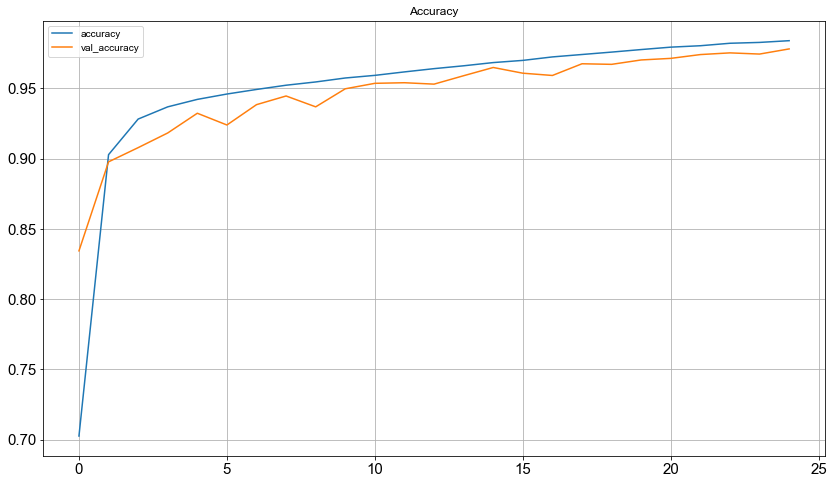

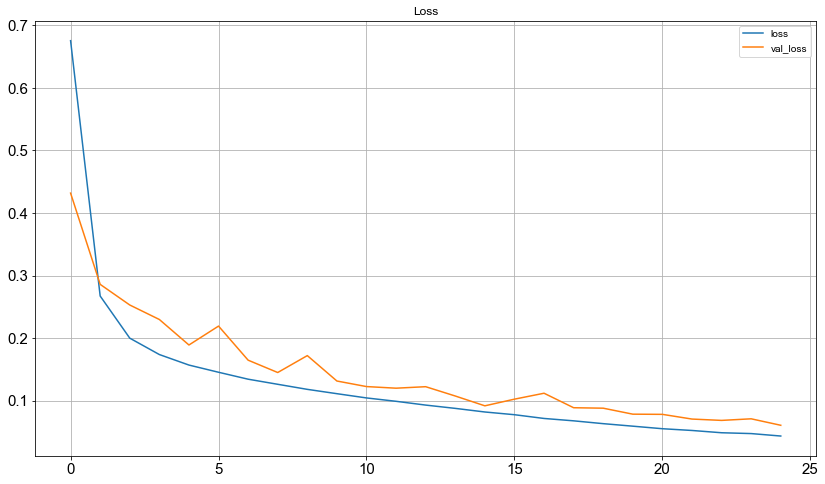

In [54]:
history_df[['accuracy','val_accuracy']].plot(figsize=(14,8),title='Accuracy',grid=True,fontsize=15)
history_df[['loss','val_loss']].plot(figsize=(14,8),title='Loss',grid=True,fontsize=15)

In [86]:
import csv
with open('loop.csv','w') as f1:
    writer=csv.writer(f1, delimiter='\t',lineterminator='\n',)
    for i in range(0,10):
       row = [i]
       writer.writerow(row)